# Filtracja bilateralna

## Konwolucja obrazu z filtrem o zadanych współczynnikach

Splot (konwolucję) obrazu wejściowego $I$ z filtrem $\psi$ dla ustalonego punktu obrazu $\mathbf{x}$ można przedstawić następująco:

\begin{equation}
\hat{I}(\mathbf{x}) = \frac{1}{W_N}\sum_{\mathbf{p} \in \eta(\mathbf{x})} \psi(||\mathbf{p}-\mathbf{x}||)I(\mathbf{p})
\end{equation}

gdzie:
- $\hat{I}$ jest obrazem wynikowym (przefiltrowanym),
- $W_N = \sum_y \psi(y)$ jest parametrem normalizującym współczynniki filtra $\psi$,
- $||\cdot||$ jest odległością między punktami obrazu $\mathbf{x}$ i $\mathbf{p}$ według ustalonej metryki (np. norma $L_2$). Uwaga, proszę pamiętać, że zarówno $\mathbf{x}$, jak i $\mathbf{p}$ to współrzędne przestrzenne,
- $\eta(\mathbf{x})$ jest otoczeniem punktu $\mathbf{x}$.

Funkcja $\psi$ decyduje o charakterze filtracji. Dla filtru Gaussowskiego:

\begin{equation}
\psi(y) = G_{\delta_s}(y)
\end{equation}

gdzie: $G_{\delta_s}(y)$ jest funkcją Gaussa z parametrem skali $\delta_s$.

Opisaną powyżej filtrację realizowaliśmy w ramach ćwiczenia "Przetwarzanie wstępne. Filtracja kontekstowa."

## Filtracja bilateralna

Wadą klasycznego splotu jest brak adaptacji współczynników filtra do lokalnego otoczenia $\eta(\mathbf{x})$ filtrowanego punktu $\mathbf{x}$.
Oznacza to wykorzystanie tych samych współczynników filtra $\psi$ niezależnie od tego czy otoczenie jest względnie jednorodne lub zawiera krawędzie obiektów (w tym przypadku dochodzi do "rozmywania" krawędzi).
Filtracja bilateralna uwzględnia lokalne otoczenie filtrowanego punktu, w ten sposób, że parametry filtra zmieniają się w zależności od "wyglądu" otocznia.


Współczynniki filtra obliczane są na podstawie odległości filtrowanego punktu $\mathbf{x}$ od każdego punktu otoczenia $\mathbf{p}$ w dziedzinie przestrzennej obrazu (tak jak przy typowym filtrze np. Gaussa) oraz odległości punktów w przeciwdziedzinie obrazu (np. na podstawie różnicy w jasności pikseli dla obrazu w odcieniach szarości):

\begin{equation}
\hat{I}(\mathbf{x}) = \frac{1}{W_N}\sum_{\mathbf{p} \in \eta(\mathbf{x})} \psi(||\mathbf{p}-\mathbf{x}||) \gamma(|I(\mathbf{p}) - I(\mathbf{x})|) I(\mathbf{p})
\end{equation}
gdzie:
- $W_N$ jest współczynnikiem normalizującym filtr,
- $\gamma$ jest funkcją odległości w przeciwdziedzinie obrazu, np. $\gamma(y)=\exp(-\frac{y^2}{2\delta_r^2})$
- parametr $\delta_r$ jest utożsamiany z poziomem szumu w obrazie i należy go dobrać w sposób empiryczny.

Proszę chwilę zastanowić się nad powyższym równaniem, w szczególności nad funkcją $\gamma$. Proszę wyznaczyć, jaka będzie wartość funkcji dla pikseli podobnych (różnica 0, 1, 2), a skrajnie różnych (255, 200).

##  Realizacja ćwiczenia

### Wczytanie danych

1. Wczytaj dane z pliku *MR_data.mat*. W tym celu wykorzystaj funkcję `loadmat` z pakietu scipy:
        from scipy.io import loadmat
        mat = loadmat('MR_data.mat')

2. Wczytany plik zawiera 5 obrazów: *I_noisefree*, *I_noisy1*, *I_noisy2*, *I_noisy3* oraz *I_noisy4*. Odczytać je można w następujący sposób:
        Input = mat['I_noisy1']

3.Wyświetl wybrany obraz z pliku *MR_data.mat*. Zagadka - co to za obrazowanie medyczne?

In [23]:
import cv2
import os
import requests
from matplotlib import pyplot as plt
import numpy as np
from scipy import signal
from scipy.io import loadmat
import math

url = 'https://raw.githubusercontent.com/vision-agh/poc_sw/master/07_Bilateral/'

fileNames = ["MR_data.mat"]
for fileName in fileNames:
  if not os.path.exists(fileName):
      r = requests.get(url + fileName, allow_redirects=True)
      open(fileName, 'wb').write(r.content)

In [24]:
def plot_with_diff(I1, I2, t1="Original", t2=''):
    fig, axs = plt.subplots(1, 3)
    n = 4
    fig.set_size_inches(3 * n, n)

    axs[0].imshow(I1, 'gray', vmin=0, vmax=256)
    axs[0].axis('off')
    axs[0].title.set_text(t1)

    axs[1].imshow(I2, 'gray', vmin=0, vmax=256)
    axs[1].axis('off')
    axs[1].title.set_text(t2)

    diff = np.abs(I1 - I2)
    axs[2].imshow(diff, 'gray')
    axs[2].axis('off')
    axs[2].title.set_text("Difference")

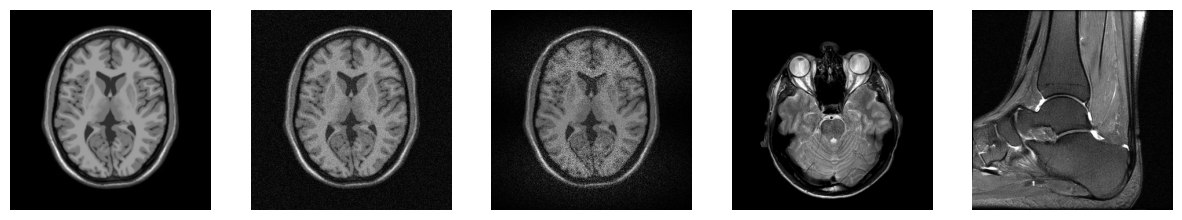

In [25]:
mat_dict = loadmat("MR_data.mat")
I_noisefree = mat_dict['I_noisefree']
I_noisy1 = mat_dict['I_noisy1']
I_noisy2 = mat_dict['I_noisy2']
I_noisy3 = mat_dict['I_noisy3']
I_noisy4 = mat_dict['I_noisy4']

Images = [I_noisefree, I_noisy1, I_noisy2, I_noisy3, I_noisy4]

f, axes = plt.subplots(1,5)
f.set_size_inches(15, 5)
for i, I in enumerate(Images):
    axes[i].imshow(I, 'gray')
    axes[i].axis('off')    

### "Klasyczna" konwolucja

1. Zdefiniuj parametry filtra Gaussowskiego: rozmiar okna i wariancję $\delta_S$.
2. Oblicz współczynniki filtra na podstawie zdefiniowanych parametrów (najprościej w ramach podwójnej pętli for).
2. Sprawdź ich poprawność i zwizualizuj filtr (tak jak w ćwiczeniu pt. "Przetwarzanie wstępne. Filtracja kontekstowa.").
3. Wykonaj kopię obrazu wejściowego: `IConv = Input.copy()`
4. Wykonaj podwójną pętlę po obrazie. Pomiń ramkę, dla której nie jest zdefiniowany kontekst o wybranej wielkości.
5. W każdej iteracji stwórz dwuwymiarową tablicę zawierającą aktualny kontekst.
6. Napisz funkcję, która będzie obliczała nową wartość piksela.
Argumentem tej funkcji są aktualnie przetwarzane okno i współczynniki filtra.
7. Obliczoną wartość przypisz do odpowiedniego piksela kopii obrazu wejściowego.
8. Wyświetl wynik filtracji.
9. Porównaj wynik z obrazem oryginalnym.

In [26]:
# funkcje z zeszłego semestru

def fgaussian(size, sigma):
     m = n = size
     h, k = m//2, n//2
     x, y = np.mgrid[-h:h+1, -k:k+1]
     g = np.exp(-(x**2 + y**2)/(2*sigma**2))
     return g /g.sum()
 
def mesh(fun, size):
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    

    X = np.arange(-size//2, size//2, 1)
    Y = np.arange(-size//2, size//2, 1)
    X, Y = np.meshgrid(X, Y)
    Z = fun
    
    ax.plot_surface(X, Y, Z)
    
    plt.show()

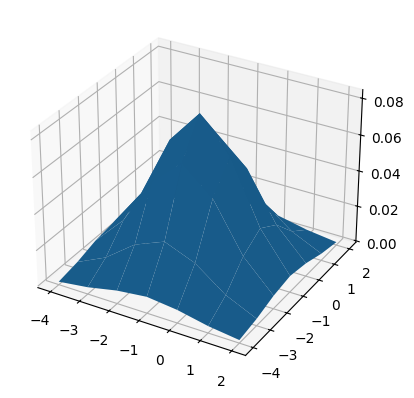

In [27]:
sigma = 1.4
size = 7
mask = fgaussian(size, sigma)
mesh(mask, size)

In [28]:
def gaussian_convolution(I, size=5, sigma=0.5):
    filter = fgaussian(size, sigma)
    I_copy = I.copy()
    width, height = I.shape
    r = size // 2
    for x in range(r, width - r):
        for y in range(r, height - r):
            window = I[x - r: x + r + 1, y - r: y + r + 1]
            I_copy[x, y] = int(np.sum(window * filter))
    return I_copy   

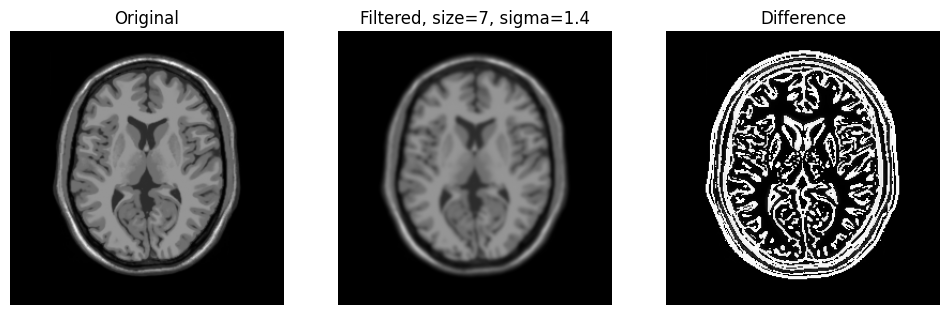

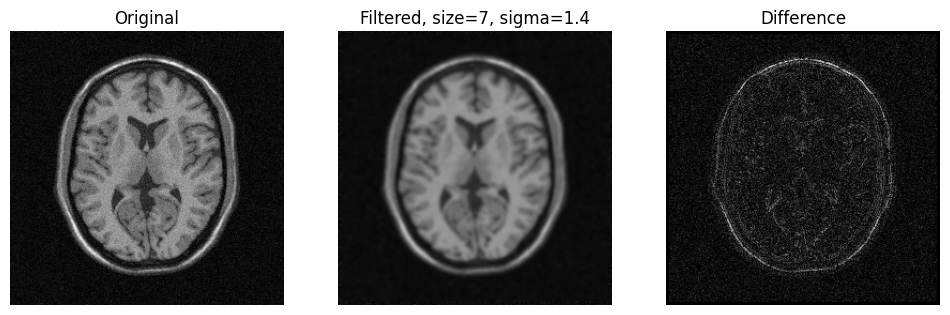

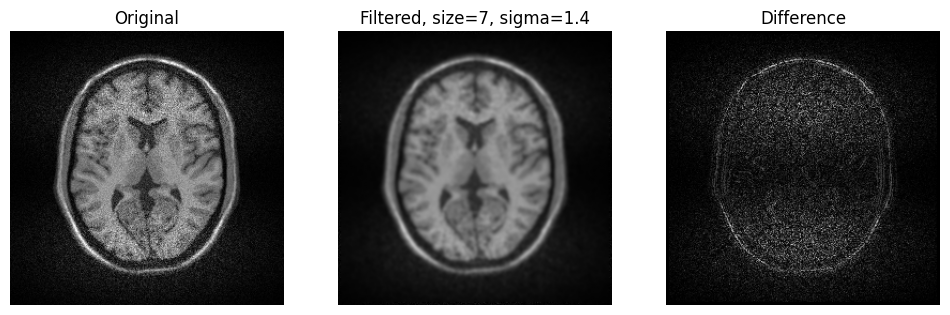

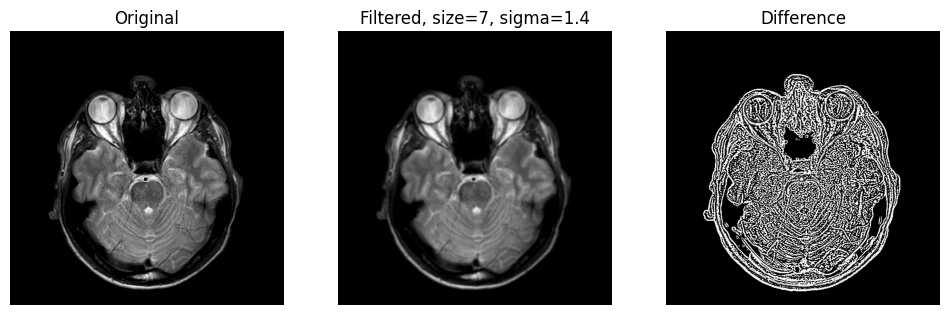

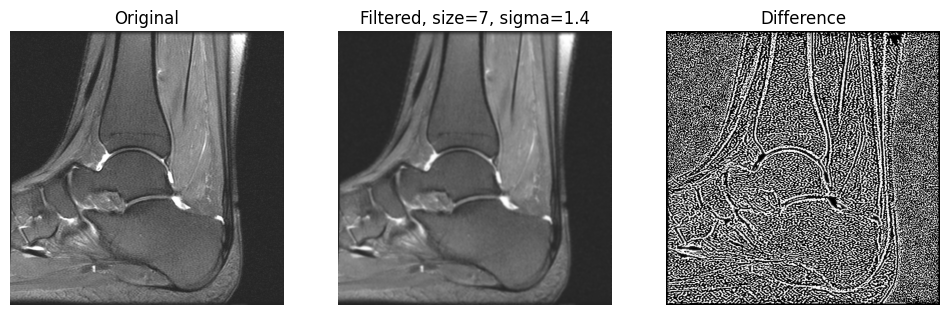

In [29]:
sigma = 1.4
size = 7
for I in Images:
    plot_with_diff(I, gaussian_convolution(I, size, sigma), t2=f"Filtered, size={size}, sigma={sigma}")

### Filtracja bilateralna

1. Zdefiniuj dodatkowy parametr: wariancję $\delta_R$.
3. Wykonaj kopię obrazu wejściowego: `IBilateral = Input.copy()`
4. Wykonaj podwójną pętlę po obrazie. Pomiń ramkę, dla której nie jest zdefiniowany kontekst o wybranej wielkości.
5. W każdej iteracji stwórz dwuwymiarową tablicę zawierającą aktualny kontekst.
6. Napisz funkcję, która będzie obliczała nową wartość piksela.
Argumentami funkcji są aktualnie przetwarzane okno, współczynniki filtra gausowskiego (takie same jak wcześniej) i wariancja $\delta_R$.
7. Oblicz odległość w przeciwdziedzinie (dla wartości pikseli).
8. Oblicz funkcję Gaussa dla obliczonych odległości z zadanym parametrem.
9. Wykonaj normalizację obliczonych współczynników.
10. Obliczoną wartość przypisz do odpowiedniego piksela kopii obrazu wejściowego.
11. Wyświetl wynik filtracji.
12. Porównaj wynik z obrazem oryginalnym.

In [30]:
def gamma(y_diff, var):
    return np.exp(-(y_diff ** 2) / (2 * var ** 2))

def new_value_var(window, filter, var):
    size = window.shape[0] // 2
    new_window = gamma(window[size, size] - window, var) * filter
    val = np.sum(new_window * window) / np.sum(new_window)
    return int(val)

def bilateral_filter(I, var, size=5, sigma=0.5):
    filter = fgaussian(size, sigma)
    I_copy = I.copy()
    width, height = I.shape
    r = size // 2
    for x in range(r, width - r):
        for y in range(r, height - r):
            window = I[x - r: x + r + 1, y - r: y + r + 1]
            I_copy[x, y] = new_value_var(window, filter, var)
    return I_copy

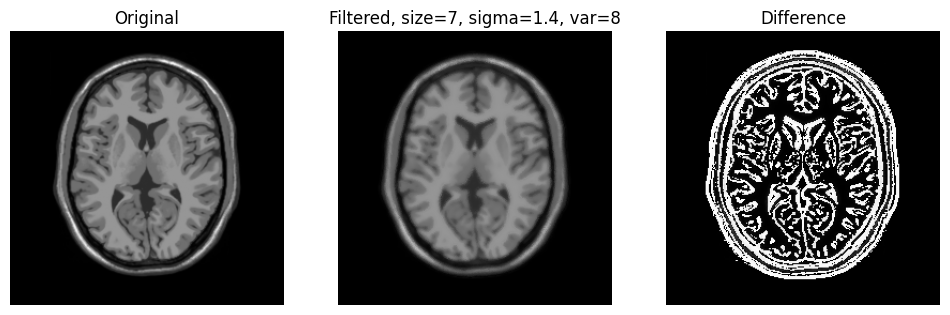

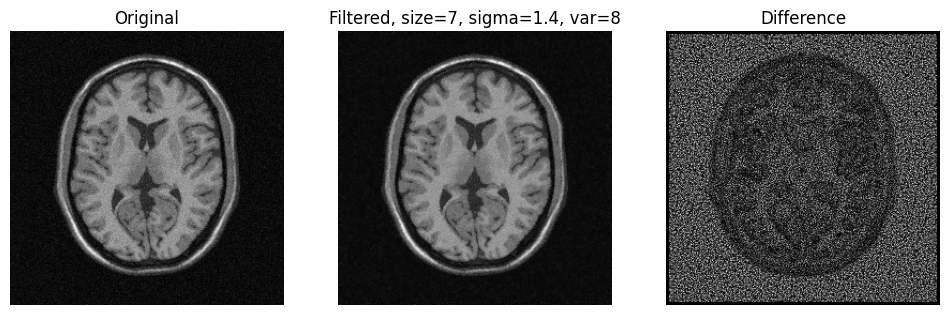

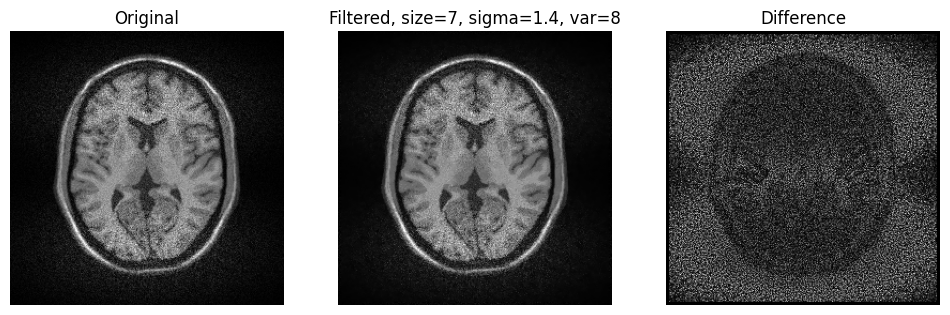

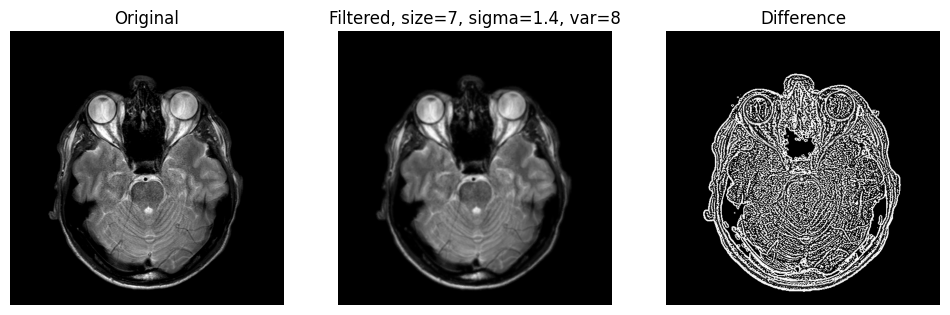

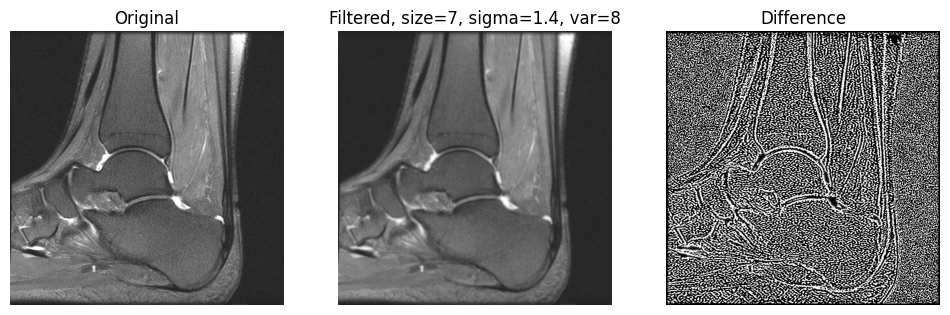

In [31]:
sigma = 1.4
size = 7
var = 8

for I in Images:
    plot_with_diff(I, bilateral_filter(I, var, size, sigma), t2=f"Filtered, size={size}, sigma={sigma}, var={var}")

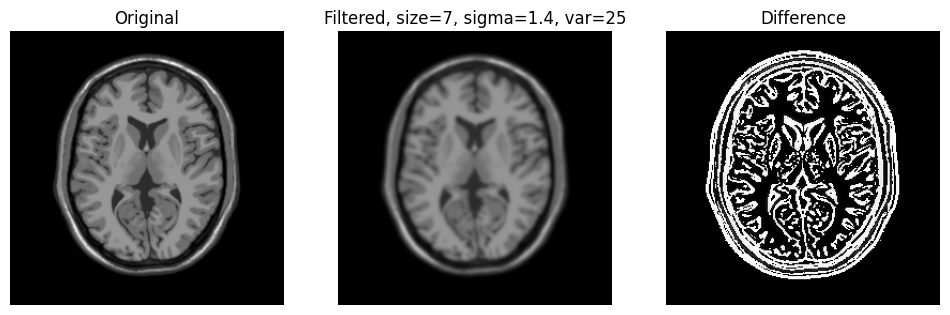

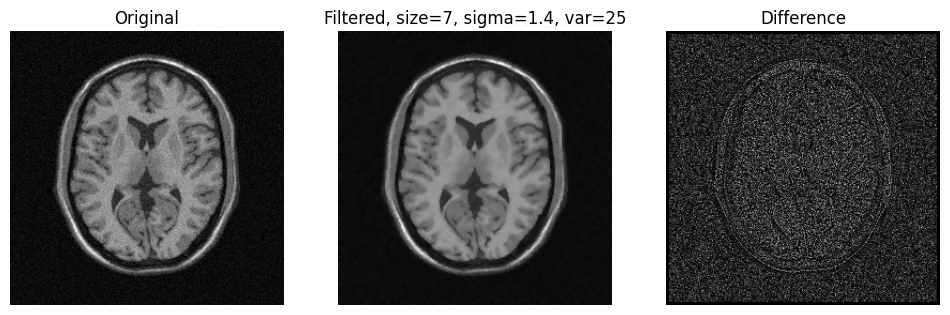

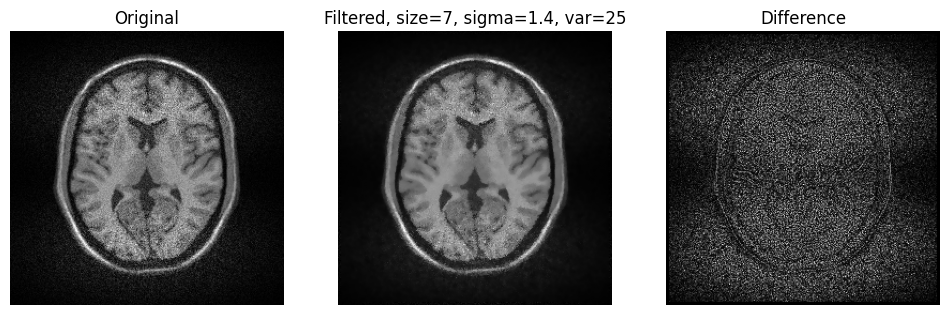

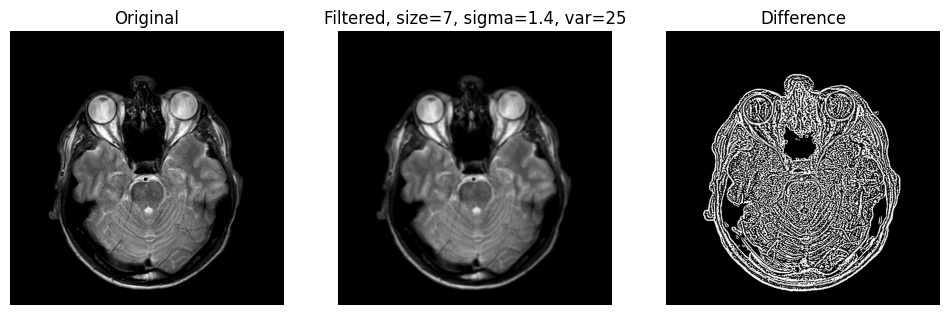

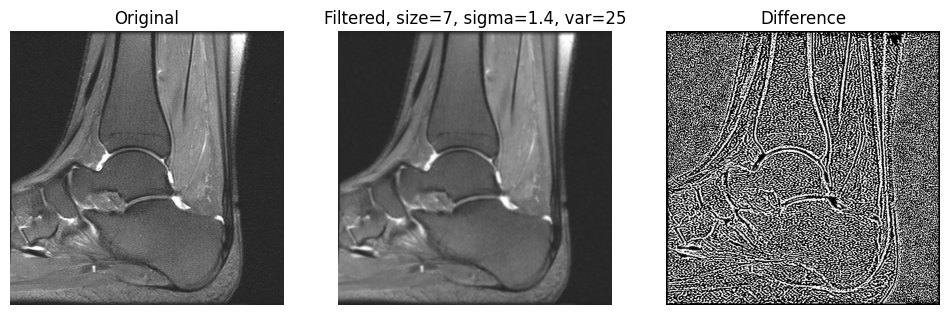

In [32]:
sigma = 1.4
size = 7
var = 25

for I in Images:
    plot_with_diff(I, bilateral_filter(I, var, size, sigma), t2=f"Filtered, size={size}, sigma={sigma}, var={var}")